In [1]:
import torch 
import numpy as np
from torchvision import datasets  
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# number of subprocesses to use for data loading
num_workers = 0                                            

# how many samples per batch to load
batch_size = 10                                      

# convert data to torch.FloatTensor
transform = transforms.ToTensor()                           

In [3]:
# choose the training datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
# choose the test datasets
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)   

In [4]:
# prepare data loaders                                                                     
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [5]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader

In [7]:
train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [8]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
test_loader.dataset.data.shape

torch.Size([10000, 28, 28])

tensor(4)


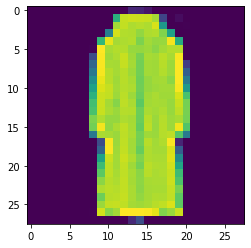

In [10]:
i = 8569
print(train_loader.dataset.targets[i])
plt.imshow(train_loader.dataset.data[i])#, cmap = "gray")

In [11]:
np.where(train_loader.dataset.targets==5)[0]                          #or we can use print()

array([    8,     9,    12, ..., 59983, 59995, 59999], dtype=int64)

In [12]:
(np.where(train_loader.dataset.targets==5)[0]).shape

(6000,)

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(10):

        print("clothes: " + str(i) + " index:" + str(np.where(train_loader.dataset.targets==i)[0][0]))

clothes: 0 index:1
clothes: 1 index:16
clothes: 2 index:5
clothes: 3 index:3
clothes: 4 index:19
clothes: 5 index:8
clothes: 6 index:18
clothes: 7 index:6
clothes: 8 index:23
clothes: 9 index:0


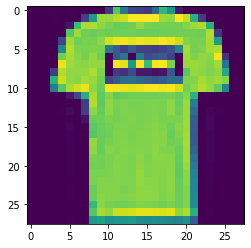

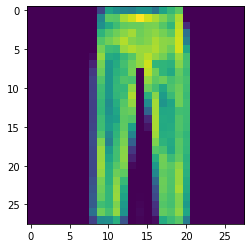

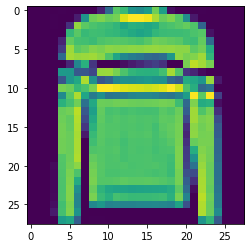

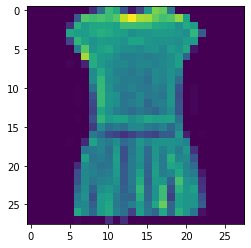

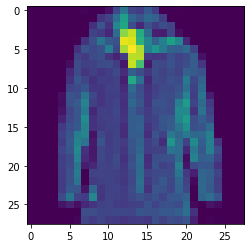

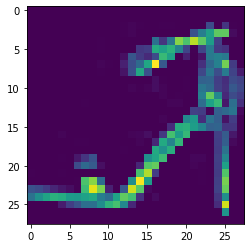

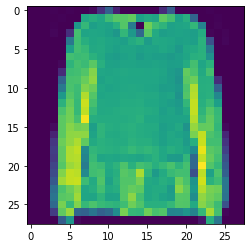

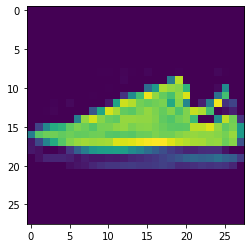

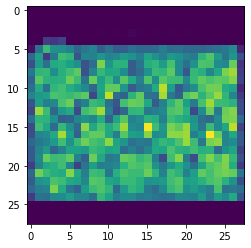

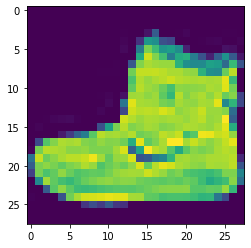

In [14]:
for i in range(10):
  ind = np.where(train_loader.dataset.targets==i)[0][0]
  plt.imshow(train_loader.dataset.data[ind])#, cmap = "gray")
  plt.show()

In [15]:
# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [17]:
# number of epochs to train the model
n_epochs = 5

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
             
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.569021
Epoch: 2 	Training Loss: 0.435669
Epoch: 3 	Training Loss: 0.399040
Epoch: 4 	Training Loss: 0.376004
Epoch: 5 	Training Loss: 0.358992


In [19]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.369010

Test Accuracy of     0: 83% (839/1000)
Test Accuracy of     1: 96% (961/1000)
Test Accuracy of     2: 82% (828/1000)
Test Accuracy of     3: 89% (893/1000)
Test Accuracy of     4: 84% (841/1000)
Test Accuracy of     5: 95% (955/1000)
Test Accuracy of     6: 45% (450/1000)
Test Accuracy of     7: 96% (963/1000)
Test Accuracy of     8: 97% (974/1000)
Test Accuracy of     9: 94% (940/1000)

Test Accuracy (Overall): 86% (8644/10000)
